<a href="https://colab.research.google.com/github/AFBA1993/Projects/blob/main/TemporalSeries/PAGS/Pags_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from keras.metrics import mean_squared_error


In [19]:
url = ('https://raw.githubusercontent.com/AFBA1993/Projects/main/'+
       'TemporalSeries/PAGS/PAGSattempt.csv')

In [20]:
url_data = requests.get(url).content
raw_data = pd.read_csv(io.StringIO(url_data.decode('utf-8')))

In [21]:
raw_data = raw_data[["Date","Close"]]

In [22]:
raw_data.index = pd.to_datetime(raw_data["Date"])
raw_data.drop("Date", axis = 1, inplace =  True)

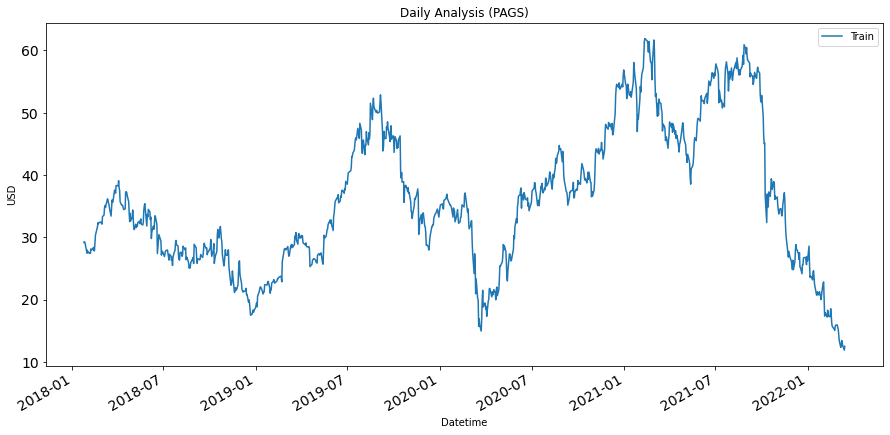

In [24]:
raw_data.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', 
                 fontsize =14, label = 'Train')
plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

## **SPLITTING DATA:**

In [25]:
SPLIT_PERCENT = 0.80
split = int(SPLIT_PERCENT*len(raw_data))
train = raw_data[:split]
test = raw_data[split:]

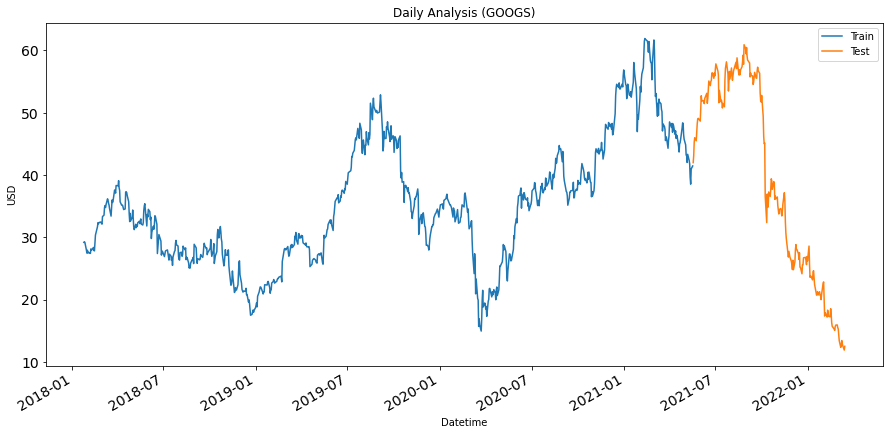

In [26]:
train.Close.plot(figsize = (15,7), label = 'Train', fontsize =14)
test.Close.plot(figsize = (15,7), title = 'Daily Analysis (GOOGS)',
                 label = 'Test', fontsize =14)

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

## **PREPARING TRAINING DATA:**

In [27]:
input_train = train.values
input_train = input_train.reshape((-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
input_train = scaler.fit_transform(input_train)

In [28]:
LOOK_BACK = 100
X_train = []
y_train = []

In [29]:
for i in range (LOOK_BACK, len(input_train)):
  X_train.append(input_train[i-LOOK_BACK:i,0])
  y_train.append(input_train[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], LOOK_BACK, 1))

In [30]:
print (X_train.shape[0], y_train.shape[0])

734 734


## **TRAINING LSTM:**

In [31]:
model = Sequential()
model.add(LSTM(units = 150, return_sequences = True,
                   input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50))
model.add(Dropout(0.3))


model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'rmsprop', loss = 'mse',
                  metrics = ['mse'])

model.fit(X_train, y_train, epochs = 100, batch_size = 32, workers=-1)

Epoch 1/100
23/23 [==============================] - 13s 288ms/step - loss: 0.0587 - mse: 0.0587
Epoch 2/100
23/23 [==============================] - 7s 288ms/step - loss: 0.0203 - mse: 0.0203
Epoch 3/100
23/23 [==============================] - 7s 288ms/step - loss: 0.0185 - mse: 0.0185
Epoch 4/100
23/23 [==============================] - 7s 288ms/step - loss: 0.0200 - mse: 0.0200
Epoch 5/100
23/23 [==============================] - 7s 292ms/step - loss: 0.0141 - mse: 0.0141
Epoch 6/100
23/23 [==============================] - 7s 284ms/step - loss: 0.0136 - mse: 0.0136
Epoch 7/100
23/23 [==============================] - 7s 306ms/step - loss: 0.0139 - mse: 0.0139
Epoch 8/100
23/23 [==============================] - 7s 285ms/step - loss: 0.0117 - mse: 0.0117
Epoch 9/100
23/23 [==============================] - 6s 281ms/step - loss: 0.0104 - mse: 0.0104
Epoch 10/100
23/23 [==============================] - 7s 287ms/step - loss: 0.0111 - mse: 0.0111
Epoch 11/100
23/23 [==================

## **LSTM in the train dataset**

In [37]:
LSTM_train = model.predict(X_train)
LSTM_train = scaler.inverse_transform(LSTM_train)
LSTM_train = pd.DataFrame(LSTM_train, columns = ['Close'])

In [38]:
LSTM_train["Date"] = train[LOOK_BACK:].index
LSTM_train.index = pd.to_datetime(LSTM_train["Date"])
LSTM_train.drop("Date", axis = 1, inplace =  True)

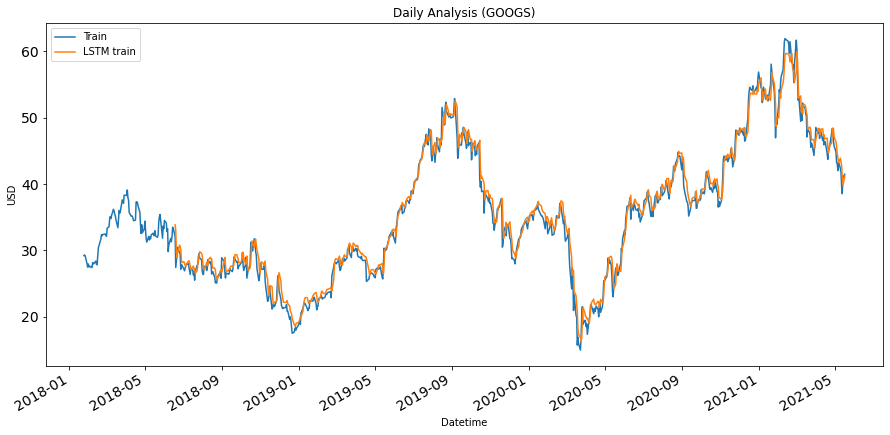

In [44]:
train.Close.plot(figsize = (15,7), label = 'Train', fontsize =14)
LSTM_train.Close.plot(figsize = (15,7), title = 'Daily Analysis (GOOGS)',
                 label = 'LSTM train', fontsize =14)

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

## **LSTM in the Test dataset:**

In [49]:
complete_data = raw_data.values
input_test = complete_data[len(complete_data) - len(test) - LOOK_BACK:]
input_test = input_test.reshape((-1, 1))
input_test = scaler.transform(input_test)

In [50]:
X_test = []
for i in range(LOOK_BACK, len(input_test)):
  X_test.append(input_test[i-LOOK_BACK:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [54]:
LSTM_test = model.predict(X_test)
LSTM_test = scaler.inverse_transform(LSTM_test)

In [59]:
LSTM_test = pd.DataFrame(LSTM_test, columns = ['Close'])
LSTM_test["Date"] = test.index
LSTM_test.index = pd.to_datetime(LSTM_test["Date"])
LSTM_test.drop("Date", axis = 1, inplace =  True)

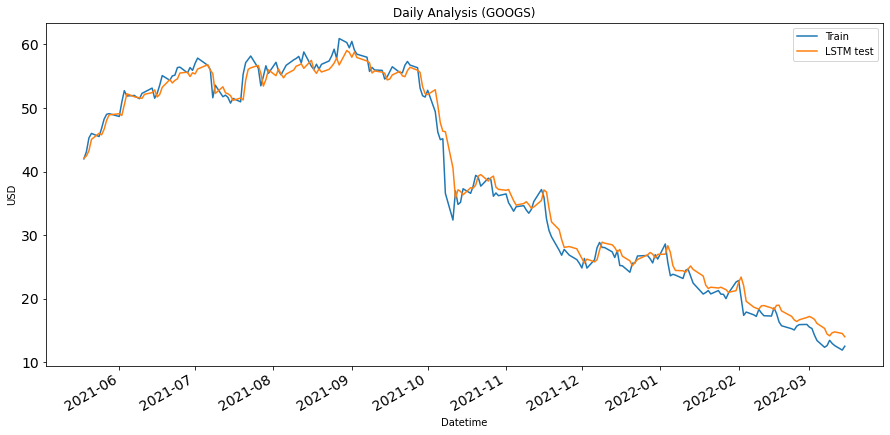

In [60]:
test.Close.plot(figsize = (15,7), label = 'Train', fontsize =14)
LSTM_test.Close.plot(figsize = (15,7), title = 'Daily Analysis (GOOGS)',
                 label = 'LSTM test', fontsize =14)

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

## **Forecasting:**

In [153]:
FORECAST_DAYS = 300
forecasted_lst = []

In [154]:
input_forecast = test[len(test) - LOOK_BACK :].values
input_forecast = scaler.fit_transform(input_forecast)
input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))

In [155]:
for i in range(FORECAST_DAYS):
  forecast = model.predict(input_forecast)
  forecasted_lst.append(forecast)
  input_forecast = np.reshape(input_forecast, (input_forecast.shape[1], 1))
  input_forecast = np.concatenate((input_forecast,forecast))
  input_forecast = input_forecast[-LOOK_BACK:]
  input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))


In [156]:
forecasted_lst = np.array(forecasted_lst)
forecasted_lst = forecasted_lst.reshape((-1, 1))
forecasted_lst = scaler.inverse_transform(forecasted_lst)

In [157]:
last_test_date = test.index[-1]
initial_forecast_date = pd.date_range(last_test_date, periods = 2, freq='D' )
initial_forecast_date = initial_forecast_date[-1]
initial_forecast_date

Timestamp('2022-03-16 00:00:00', freq='D')

In [158]:
forecast_dates = pd.date_range(initial_forecast_date, periods = 
                                      FORECAST_DAYS, freq='D')


In [159]:
LSTM_forecast = pd.DataFrame(forecasted_lst, columns = ['Close'])
LSTM_forecast["Date"] = forecast_dates
LSTM_forecast.index = LSTM_forecast["Date"]
LSTM_forecast.drop("Date", axis = 1, inplace =  True)

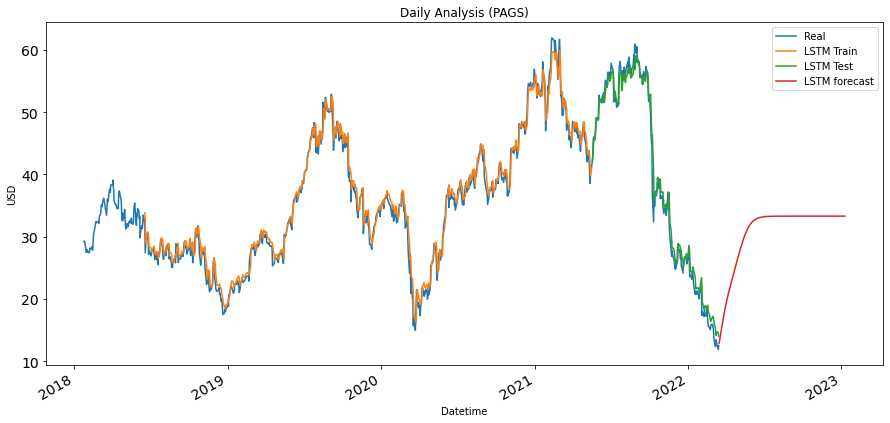

In [162]:
raw_data.Close.plot(figsize = (15,7), label = 'Real')
LSTM_train.Close.plot(figsize = (15,7), label = 'LSTM Train')
LSTM_test.Close.plot(figsize = (15,7), label = 'LSTM Test')
LSTM_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', 
                 fontsize =14, label = 'LSTM forecast')

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')